In [1]:
from __future__ import print_function

import math

from IPython import display
import matplotlib as mpl
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
import os
import sys
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset
import tensorflow_datasets as tfds
from IPython import display
from six.moves import urllib

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format


mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.grid'] = False

# tf.random.set_seed(13)

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd '/content/drive/My Drive/NFL/Data/'
# %ls '/content/drive/My Drive/NFL/Data/'

/content/drive/My Drive/NFL/Data


In [4]:
#import data
nfl = pd.read_excel('NFL_1619.xls', sheet_name='NFL_1619')
nfl.head()

,Team,Year,Week,Day,Date,Time,WinOrNot,OT,HomeField,Opp,Score_Tm,Score_Opp,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Defense_1stD,Defense_TotYd,Defense_PassY,Defense_RushY,Defense_TO,ExpectedPoints_Offense,ExpectedPoints_Defense,ExpectedPoints_SpTms
0,Philadelphia Eagles,2019,1,Sun,2019-09-08,1:00PM ET,1,0,0,Washington Redskins,32,27,22,436,313,123,0,15,398,370,28,0,18.7,-12.1,0.6
1,Philadelphia Eagles,2019,2,Sun,2019-09-15,8:20PM ET,0,0,1,Atlanta Falcons,20,24,18,286,237,49,3,19,367,310,57,3,-3.2,-4.0,4.0
2,Philadelphia Eagles,2019,3,Sun,2019-09-22,1:00PM ET,0,0,0,Detroit Lions,24,27,22,373,246,127,2,16,287,201,86,0,-0.3,-1.1,-3.8
3,Philadelphia Eagles,2019,4,Thu,2019-09-26,8:20PM ET,1,0,1,Green Bay Packers,34,27,24,336,160,176,0,31,491,414,77,2,19.4,-16.9,4.1
4,Philadelphia Eagles,2019,5,Sun,2019-10-06,1:00PM ET,1,0,0,New York Jets,31,6,17,265,181,84,1,9,128,61,67,3,-4.6,34.6,-6.4


## Data Preprocessing

In [5]:
nfl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2134 entries, 0 to 2133
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Team                    2134 non-null   object        
 1   Year                    2134 non-null   int64         
 2   Week                    2134 non-null   object        
 3   Day                     2134 non-null   object        
 4   Date                    2134 non-null   datetime64[ns]
 5   Time                    2134 non-null   object        
 6   WinOrNot                2134 non-null   object        
 7   OT                      2134 non-null   int64         
 8   HomeField               2121 non-null   object        
 9   Opp                     2134 non-null   object        
 10  Score_Tm                2134 non-null   int64         
 11  Score_Opp               2134 non-null   int64         
 12  Offense_1stD            2134 non-null   int64   

In [6]:
nfl.describe()

,Year,OT,Score_Tm,Score_Opp,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Defense_1stD,Defense_TotYd,Defense_PassY,Defense_RushY,Defense_TO,ExpectedPoints_Offense,ExpectedPoints_Defense,ExpectedPoints_SpTms
count,2134.0,2134.0,2134.0,2134.0,2134.0,2134.0,2134.0,2134.0,2134.0,2134.0,2134.0,2134.0,2134.0,2134.0,2134.0,2134.0,2134.0
mean,2017.5,0.1,22.7,22.7,20.1,346.7,235.3,111.4,1.4,20.1,346.7,235.3,111.4,1.4,3.0,-3.0,-0.0
std,1.1,0.2,10.0,10.0,5.0,85.1,78.0,50.8,1.2,5.0,85.1,78.0,50.8,1.2,12.3,12.3,5.3
min,2016.0,0.0,0.0,0.0,5.0,89.0,6.0,6.0,0.0,5.0,89.0,6.0,6.0,0.0,-39.2,-42.7,-25.9
25%,2016.2,0.0,16.0,16.0,17.0,286.0,180.0,75.0,0.0,17.0,286.0,180.0,75.0,0.0,-4.9,-11.5,-3.4
50%,2017.0,0.0,23.0,23.0,20.0,345.0,232.0,103.0,1.0,20.0,345.0,232.0,103.0,1.0,3.2,-3.2,0.0
75%,2018.0,0.0,29.0,29.0,24.0,406.0,286.0,140.0,2.0,24.0,406.0,286.0,140.0,2.0,11.5,4.9,3.4
max,2019.0,1.0,59.0,59.0,37.0,643.0,500.0,323.0,8.0,37.0,643.0,500.0,323.0,8.0,42.7,39.2,25.9


In [7]:
#select required variables
columns = ['Date', 'Team', 'Opp', 'WinOrNot',	'OT',	'HomeField', 'Score_Tm',	
            'Score_Opp',	'Offense_1stD',	'Offense_TotYd' ,'Offense_PassY',	
            'Offense_RushY',	'Offense_TO',	'Defense_1stD',	'Defense_TotYd',	
            'Defense_PassY',	'Defense_RushY',	'Defense_TO']
nfl_df = nfl[columns]
nfl_df.head()

,Date,Team,Opp,WinOrNot,OT,HomeField,Score_Tm,Score_Opp,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Defense_1stD,Defense_TotYd,Defense_PassY,Defense_RushY,Defense_TO
0,2019-09-08,Philadelphia Eagles,Washington Redskins,1,0,0,32,27,22,436,313,123,0,15,398,370,28,0
1,2019-09-15,Philadelphia Eagles,Atlanta Falcons,0,0,1,20,24,18,286,237,49,3,19,367,310,57,3
2,2019-09-22,Philadelphia Eagles,Detroit Lions,0,0,0,24,27,22,373,246,127,2,16,287,201,86,0
3,2019-09-26,Philadelphia Eagles,Green Bay Packers,1,0,1,34,27,24,336,160,176,0,31,491,414,77,2
4,2019-10-06,Philadelphia Eagles,New York Jets,1,0,0,31,6,17,265,181,84,1,9,128,61,67,3


In [8]:
#create two teams data: 49ers and chiefs
nfl_sf = nfl_df.query('Team =="San Francisco 49ers"')
nfl_ch = nfl_df.query('Team =="Kansas City Chiefs"')

nfl_sf.shape, nfl_ch.shape

((66, 18), (70, 18))

## Time Series Forecasting


In [22]:
#create time series df
cols = ['Date', 'Score_Tm','Score_Opp', 'Offense_1stD', 'Offense_TotYd',
        'Offense_PassY', 'Offense_RushY', 'Offense_TO']

nfl_sf_ts = nfl_sf[cols].set_index('Date')
nfl_ch_ts = nfl_ch[cols].set_index('Date')
nfl_sf_ts.head()

,Score_Tm,Score_Opp,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO
Date,,,,,,,
2019-09-08,31,17,17,256,158,98,2
2019-09-15,41,17,27,571,312,259,1
2019-09-22,24,20,26,436,268,168,5
2019-10-07,31,3,22,446,171,275,0
2019-10-13,20,7,22,331,232,99,2


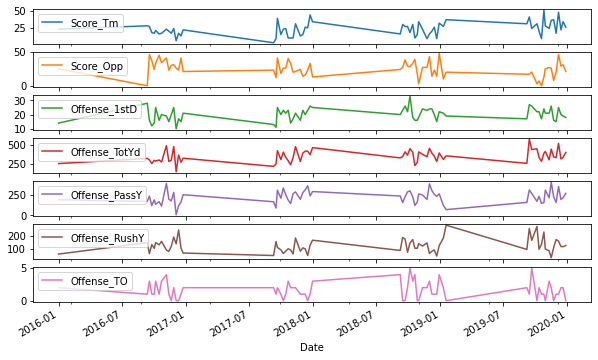

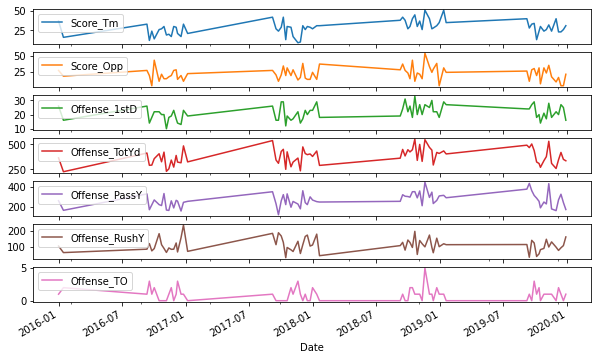

In [11]:
nfl_sf_ts.plot(subplots=True)
nfl_ch_ts.plot(subplots=True);

### ARIMA

**Test stationary of each variable using Augmented Dickey Fuller (ADF)**

In [0]:
#ADF
from statsmodels.tsa.stattools import adfuller

In [113]:
print('Chiefs')
for col in nfl_ch_ts.columns:
  print("%s - p-value:" %col , adfuller(nfl_ch_ts[col])[1])

print('')
print('SF 49ers')
for col in nfl_sf_ts.columns:
  print("%s - p-value:" %col , adfuller(nfl_sf_ts[col])[1])


Chiefs
Score_Tm - p-value: 0.13564928101373247
Score_Opp - p-value: 6.448518401660397e-15
Offense_1stD - p-value: 0.49468858326427784
Offense_TotYd - p-value: 0.0012471208029936401
Offense_PassY - p-value: 0.2686715395175023
Offense_RushY - p-value: 7.101211816184056e-14
Offense_TO - p-value: 7.612107340232606e-14

SF 49ers
Score_Tm - p-value: 0.0315913088971427
Score_Opp - p-value: 6.308195893429904e-06
Offense_1stD - p-value: 7.122354821120039e-10
Offense_TotYd - p-value: 5.3360525549807576e-14
Offense_PassY - p-value: 3.279529515163333e-11
Offense_RushY - p-value: 6.149405504518895e-10
Offense_TO - p-value: 3.3673870680734343e-13


**Find out the order of difference by plotting auto-correlation function (ACF) and Partial ACF**

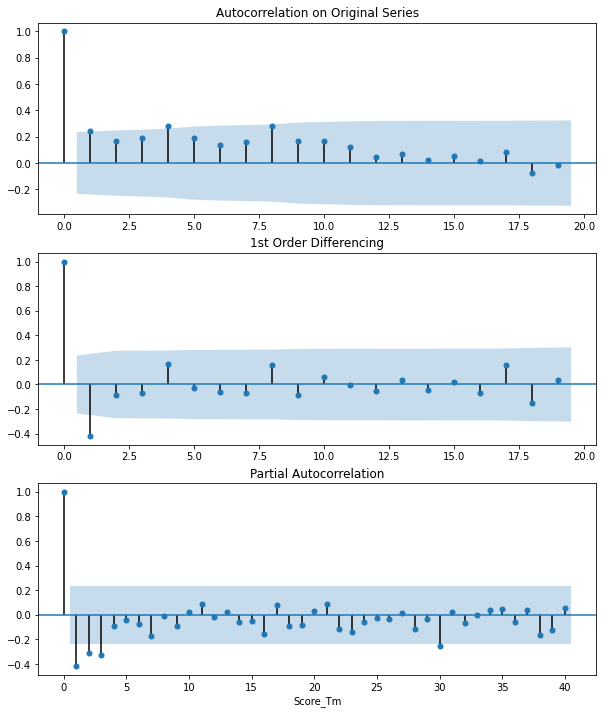

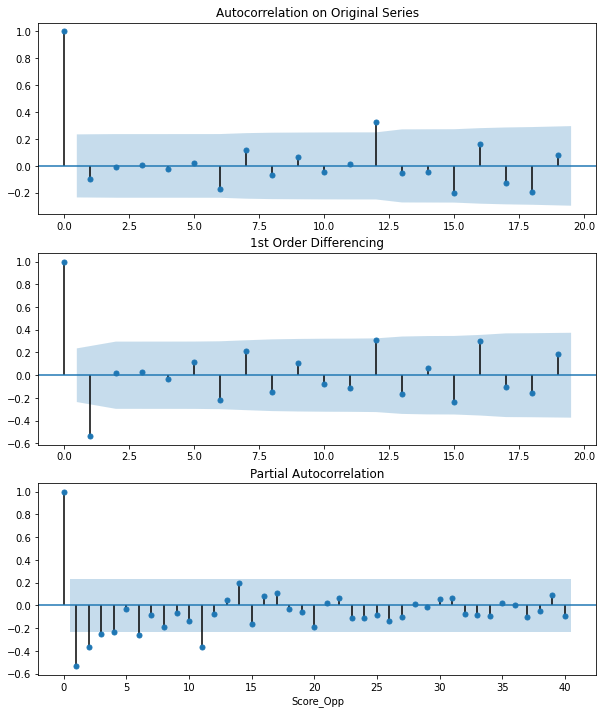

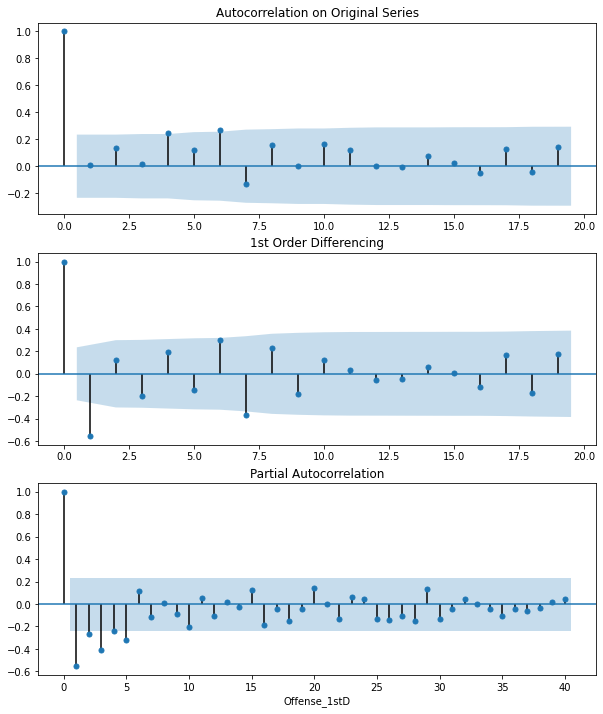

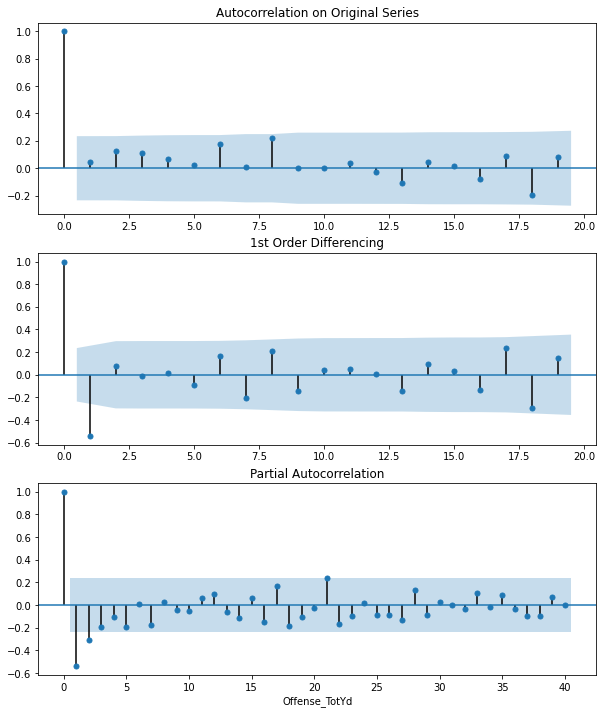

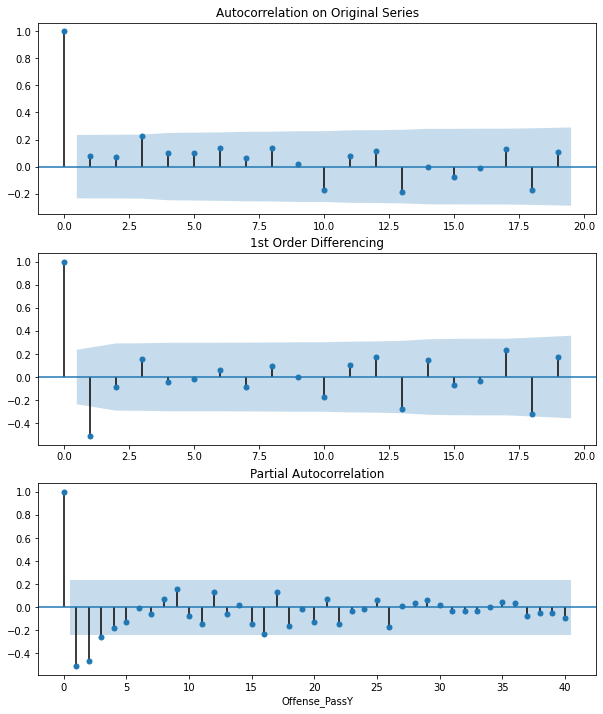

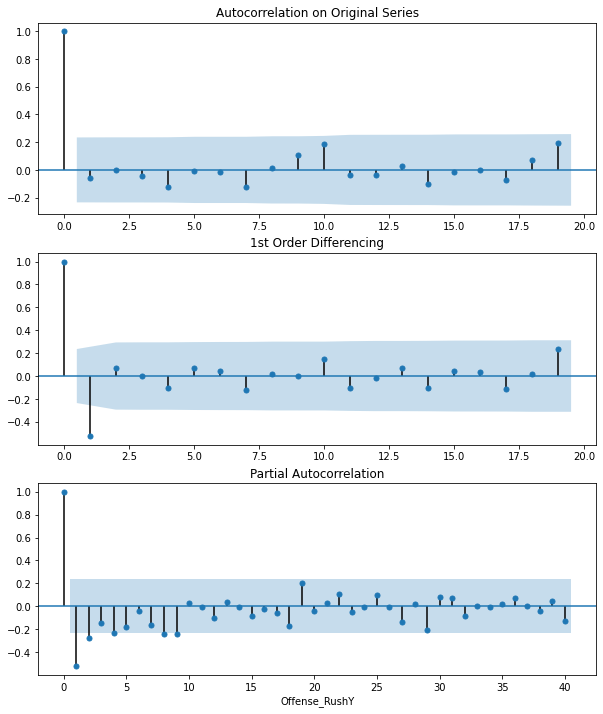

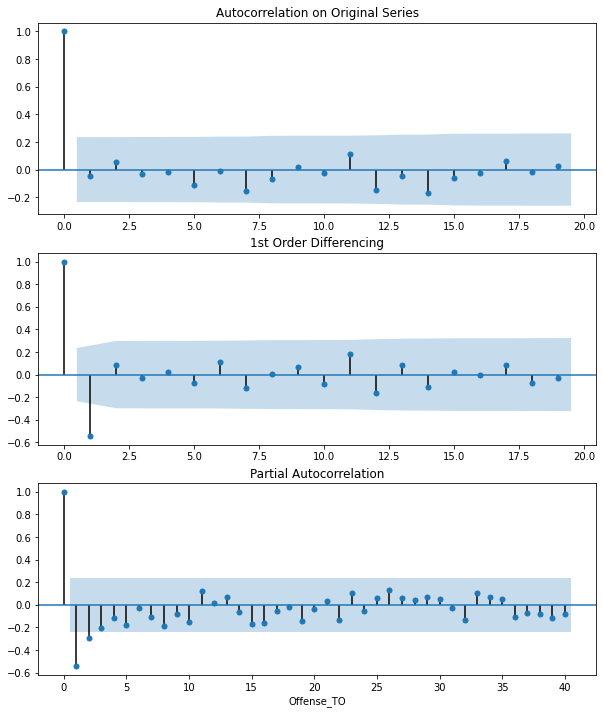

In [149]:
#ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for col in nfl_ch_ts.columns:
  fig = plt.figure(figsize=(10, 12))
  ax1 = fig.add_subplot(311)
  fig = plot_acf(nfl_ch_ts[col], ax=ax1, 
                title="Autocorrelation on Original Series") 
  ax2 = fig.add_subplot(312)
  fig = plot_acf(nfl_ch_ts[col].diff().dropna(), ax=ax2, 
                title="1st Order Differencing")
  # ax3 = fig.add_subplot(313)
  # fig = plot_acf(nfl_ch_ts[col].diff().diff().dropna(), ax=ax3, 
  #               title="2st Order Differencing")
  # ax3.set_xlabel(col);
  ax3 = fig.add_subplot(313)
  fig = plot_pacf(nfl_ch_ts[col].diff().dropna(), lags = 40, method='ywm', ax=ax3, 
                title="Partial Autocorrelation")
  ax3.set_xlabel(col);



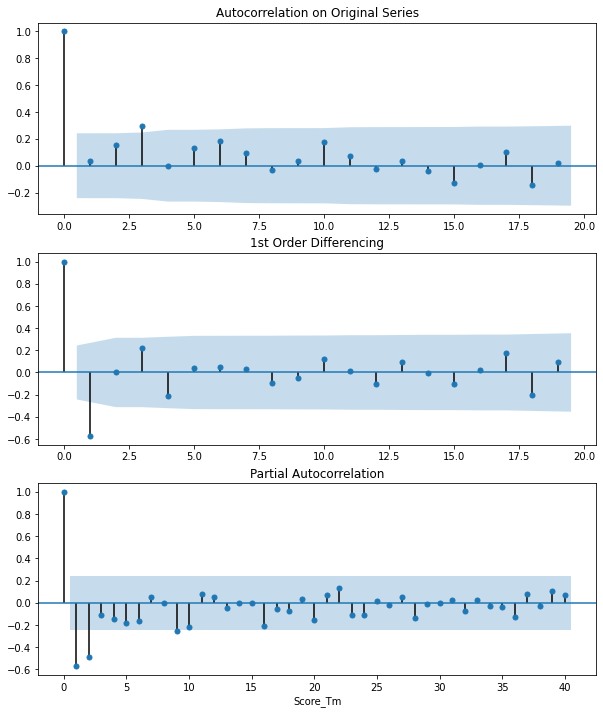

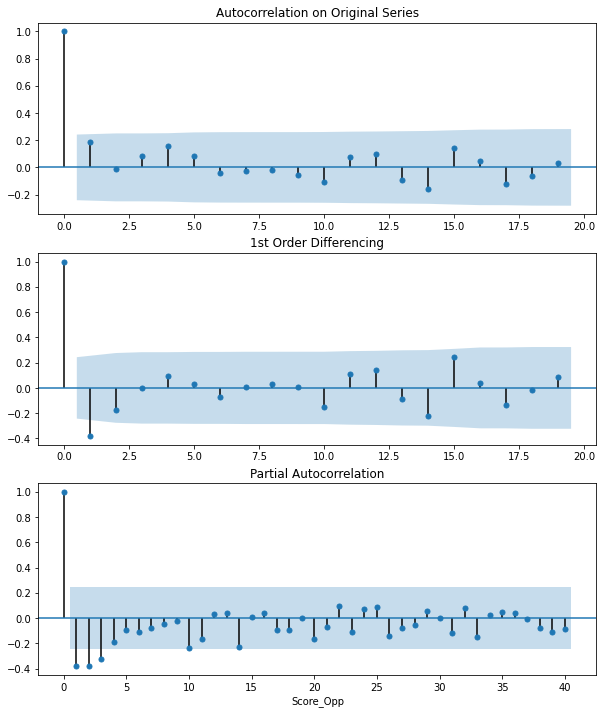

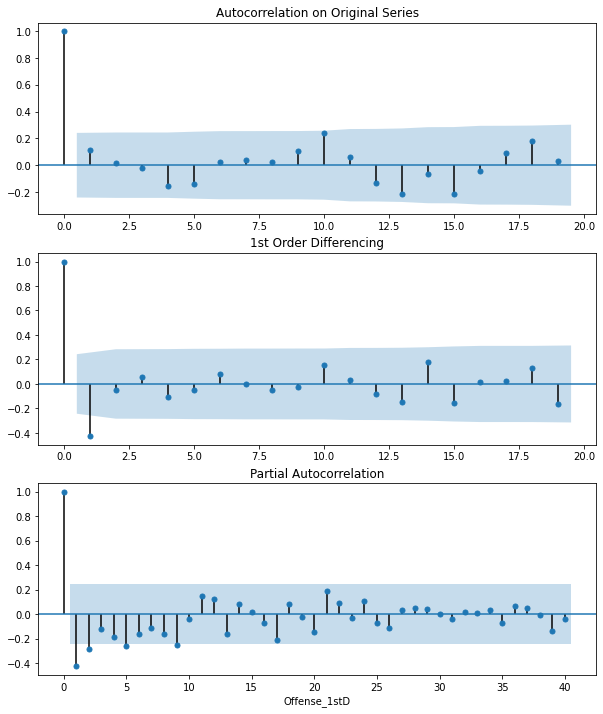

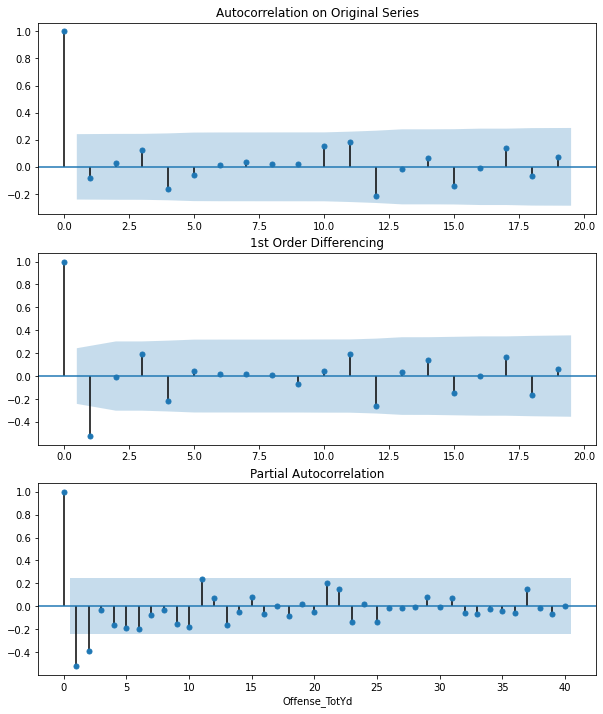

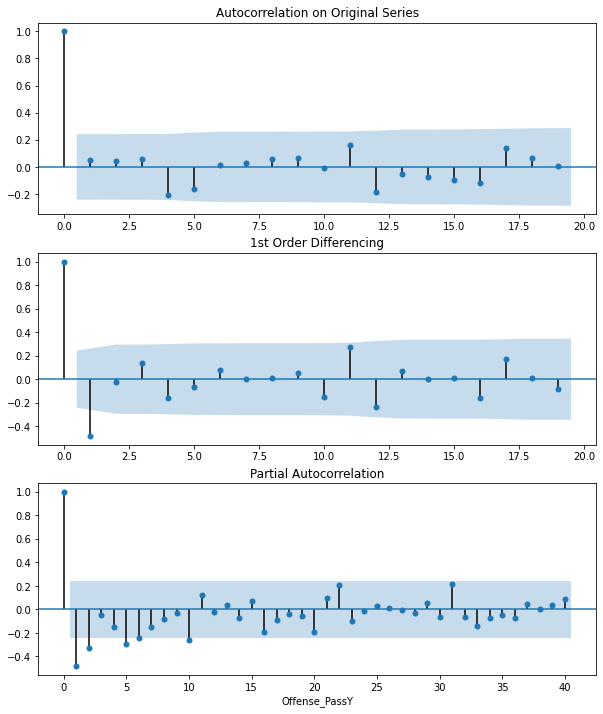

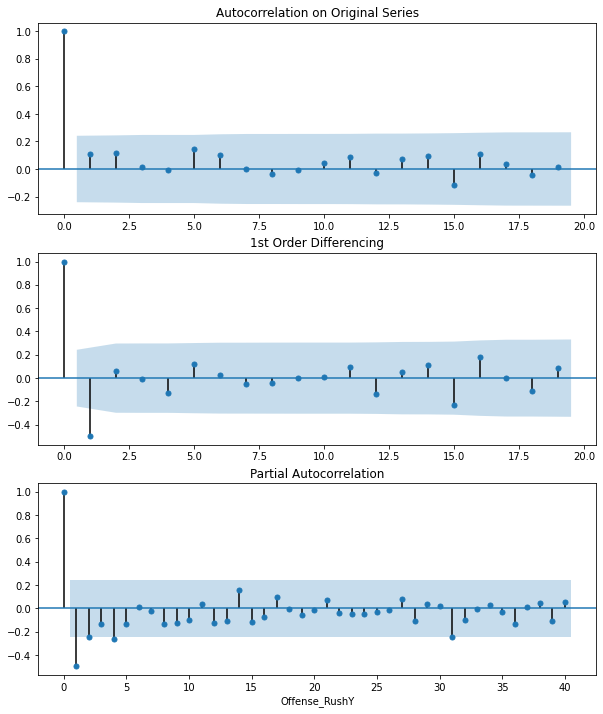

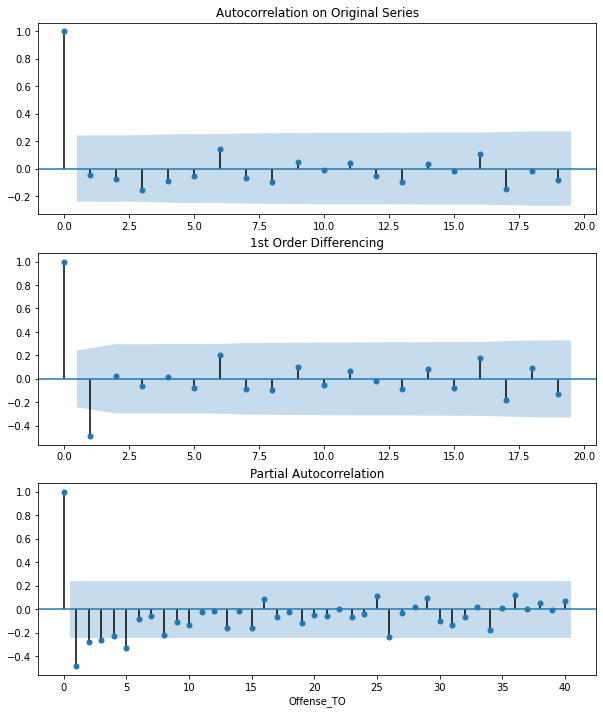

In [148]:
for col in nfl_sf_ts.columns:
  fig = plt.figure(figsize=(10, 12))
  ax1 = fig.add_subplot(311)
  fig = plot_acf(nfl_sf_ts[col], ax=ax1, 
                title="Autocorrelation on Original Series") 
  # ax1.set_xlabel(col)
  ax2 = fig.add_subplot(312)
  fig = plot_acf(nfl_sf_ts[col].diff().dropna(), ax=ax2, 
                title="1st Order Differencing")
  # ax2.set_xlabel(col)
  ax3 = fig.add_subplot(313)
  fig = plot_pacf(nfl_sf_ts[col].diff().dropna(), lags = 40, method='ywm', ax=ax3, 
                title="Partial Autocorrelation")
  ax3.set_xlabel(col);

  # ax3 = fig.add_subplot(313)
  # fig = plot_acf(nfl_sf_ts[col].diff().diff().dropna(), ax=ax3, 
  #               title="2st Order Differencing")
  # ax3.set_xlabel(col);


In [265]:
nfl_ch_ts.shape

(70, 7)

In [0]:
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime

In [0]:
import warnings
warnings.filterwarnings("ignore")

Offense_1stD:  433.00194558007297
20.002480466169885

Offense_TotYd:  820.185245143455
365.5261953453557

Offense_PassY:  797.2257376019443
249.09551920405178

Offense_RushY:  736.1473014760572
109.40511334175531

Offense_TO:  206.75689228382103
0.9017063103487976


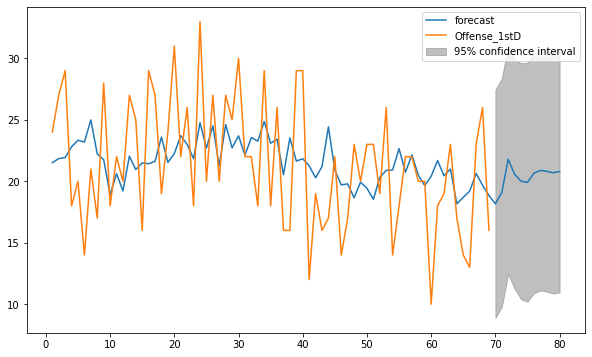

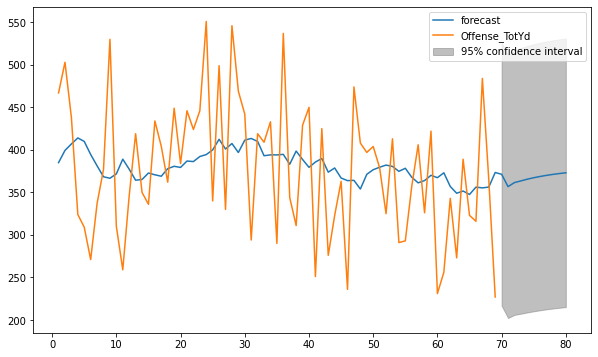

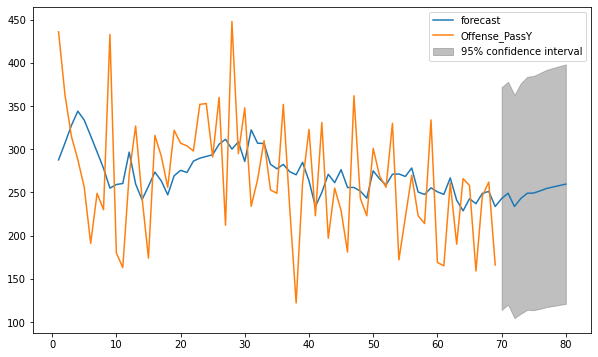

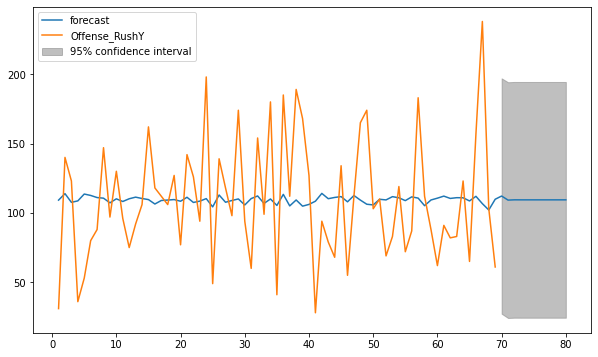

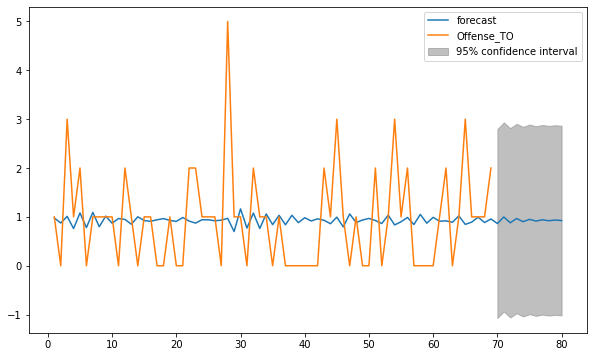

In [290]:
#modeling - Chiefs

#Offense_1stD
model = ARIMA(nfl_ch_ts.Offense_1stD, order=(5, 0, 1))
results = model.fit()
print('Offense_1stD: ', results.aic)
print(results.forecast(5)[0][4])
fig, ax = plt.subplots(1,1)
fig = results.plot_predict(1,80, ax=ax)
print("")

#Offense_TotYd
model = ARIMA(nfl_ch_ts.Offense_TotYd, order=(2, 0, 1))
results = model.fit()
print('Offense_TotYd: ', results.aic)
print(results.forecast(5)[0][4])
fig, ax = plt.subplots(1,1)
fig = results.plot_predict(1,80, ax=ax)
print("")

#Offense_PassY
model = ARIMA(nfl_ch_ts.Offense_PassY, order=(3, 0, 1))
results = model.fit()
print('Offense_PassY: ', results.aic)
print(results.forecast(5)[0][4])
fig, ax = plt.subplots(1,1)
fig = results.plot_predict(1,80, ax=ax)
print("")

#Offense_RushY
model = ARIMA(nfl_ch_ts.Offense_RushY, order=(2, 0, 1))
results = model.fit()
print('Offense_RushY: ', results.aic)
print(results.forecast(5)[0][4])
fig, ax = plt.subplots(1,1)
fig = results.plot_predict(1,80, ax=ax)
print("")

#Offense_TO
model = ARIMA(nfl_ch_ts.Offense_TO, order=(2, 0, 1))
results = model.fit()
print('Offense_TO: ', results.aic)
print(results.forecast(5)[0][4])
fig, ax = plt.subplots(1,1)
fig = results.plot_predict(1,80, ax=ax)

Offense_1stD:  390.51583424493845
17.914599614424162

Offense_TotYd:  773.6371918060186
349.135177106524

Offense_PassY:  775.9178254332973
222.4294862247682

Offense_RushY:  722.8365045842572
125.15780793229665

Offense_TO:  224.89907707783084
1.7228034098401896


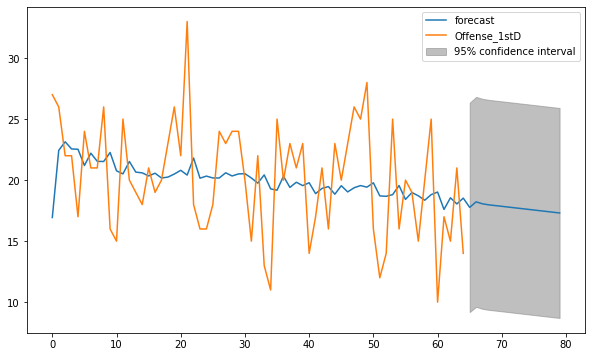

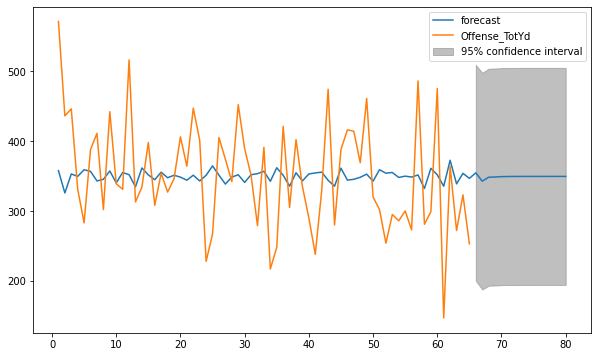

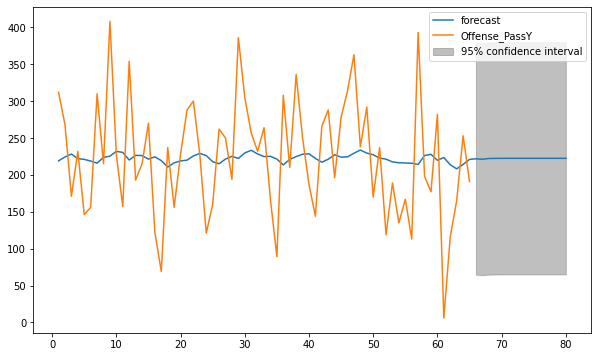

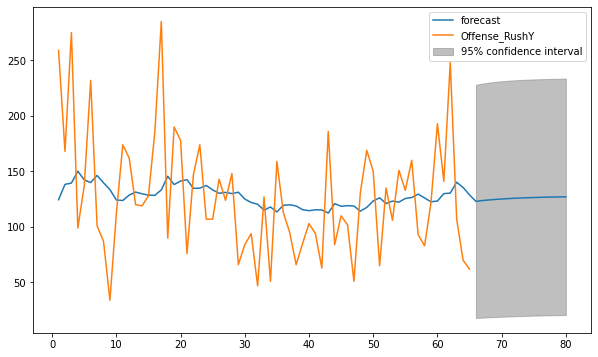

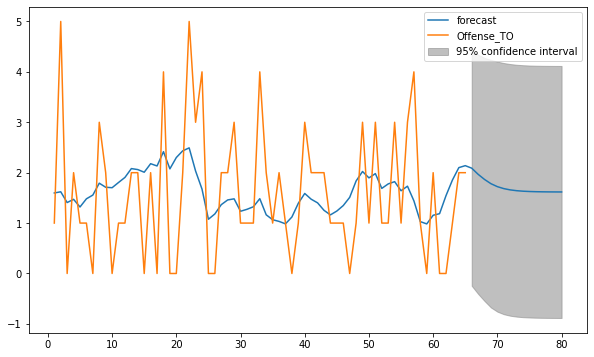

In [291]:
#modeling - SF 49ers

#Offense_1stD
model = ARIMA(nfl_sf_ts.Offense_1stD, order=(2, 1, 1))
results = model.fit()
print('Offense_1stD: ', results.aic)
print(results.forecast(5)[0][4])
fig, ax = plt.subplots(1,1)
fig = results.plot_predict(1,80, ax=ax)
print("")

#Offense_TotYd
model = ARIMA(nfl_sf_ts.Offense_TotYd, order=(2, 0, 1))
results = model.fit()
print('Offense_TotYd: ', results.aic)
print(results.forecast(5)[0][4])
fig, ax = plt.subplots(1,1)
fig = results.plot_predict(1,80, ax=ax)
print("")

#Offense_PassY
model = ARIMA(nfl_sf_ts.Offense_PassY, order=(2, 0, 1))
results = model.fit()
print('Offense_PassY: ', results.aic)
print(results.forecast(5)[0][4])
fig, ax = plt.subplots(1,1)
fig = results.plot_predict(1,80, ax=ax)
print("")

#Offense_RushY
model = ARIMA(nfl_sf_ts.Offense_RushY, order=(2, 0, 1))
results = model.fit()
print('Offense_RushY: ', results.aic)
print(results.forecast(5)[0][4])
fig, ax = plt.subplots(1,1)
fig = results.plot_predict(1,80, ax=ax)
print("")

#Offense_TO
model = ARIMA(nfl_sf_ts.Offense_TO, order=(3, 0, 1))
results = model.fit()
print('Offense_TO: ', results.aic)
print(results.forecast(5)[0][4])
fig, ax = plt.subplots(1,1)
fig = results.plot_predict(1,80, ax=ax)

In [295]:
nextgame0_dic = {'Opp': ['Kansas City Chiefs', 'San Francisco 49ers'], 
          'Offense_1stD': [20.0, 17.9], 'Offense_TotYd': [365.5, 349.1],
          'Offense_PassY': [249.1, 222.4],	'Offense_RushY': [109.4, 125.2], 
          'Offense_TO': [0.9,	1.7], 'Defense_1stD': [17.9, 20.0],
          'Defense_TotYd':[349.1, 365.5], 'Defense_PassY': [222.4, 249.1], 
          'Defense_RushY': [125.2, 109.4], 'Defense_TO': [1.7, 0.9]}

next_game0 = pd.DataFrame.from_dict(nextgame0_dic, orient = "index")
next_game0 = next_game0.T
next_game0['Score_Tm'] = 10
next_game0.iloc[:, 1:11] = next_game0.iloc[:, 1:11].apply(pd.to_numeric)
next_game0

,Opp,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Defense_1stD,Defense_TotYd,Defense_PassY,Defense_RushY,Defense_TO,Score_Tm
0,Kansas City Chiefs,20.0,365.5,249.1,109.4,0.9,17.9,349.1,222.4,125.2,1.7,10
1,San Francisco 49ers,17.9,349.1,222.4,125.2,1.7,20.0,365.5,249.1,109.4,0.9,10


### Tensorflow Time Series

In [0]:
def get_train_data(data, target):
  train_data = data.query('Date >= "2019-09-01"')
  train_unidata = train_data[target]
  return train_unidata

# def get_val_data(data, target):
#    test_data = data.query('Date >= "2019-12-01"')
#    test_unidata = test_data[target]
#    return test_unidata

def standardize(df):  
  data = df.values
  data_mean = data.mean(axis=0)
  data_std = data.std(axis=0)
  data = (data - data_mean)/data_std
  return data

def inverse(df, arr):
  data = df.values
  data_mean = data.mean(axis=0)
  data_std = data.std(axis=0)
  inv_arr = arr * data_std + data_mean
  return inv_arr

def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [307]:
#predict each performance of sf 49er
target_list = ['Offense_1stD', 'Offense_TotYd', 'Offense_PassY', 'Offense_RushY', 'Offense_TO']

for i in target_list:
  train = get_train_data(nfl_sf_ts, i)
  train_st = standardize(train)
  tf.random.set_random_seed(1)
  TRAIN_SPLIT = 11
  univariate_past_history = 10
  univariate_future_target = 0

  x_train_uni, y_train_uni = univariate_data(train_st, 0, TRAIN_SPLIT,
                                            univariate_past_history,
                                            univariate_future_target)
  x_val_uni, y_val_uni = univariate_data(train_st, TRAIN_SPLIT, None,
                                        univariate_past_history,
                                        univariate_future_target)
  
  x_arr = inverse(train, x_train_uni[0])
  y = inverse(train, y_train_uni[0])
  
  # print ('Single window of past history : {}'.format(x_arr))
  print(i)
  print('predicted values : {}'.format(y))
  print(" ")

Offense_1stD
predicted values : 16.0
 
Offense_TotYd
predicted values : 339.0
 
Offense_PassY
predicted values : 227.0
 
Offense_RushY
predicted values : 112.0
 
Offense_TO
predicted values : 0.0
 


In [308]:
#predict each performance of chiefs
target_list = ['Offense_1stD', 'Offense_TotYd', 'Offense_PassY', 'Offense_RushY', 'Offense_TO']

for i in target_list:
  train = get_train_data(nfl_ch_ts, i)
  train_st = standardize(train)
  tf.random.set_random_seed(1)
  TRAIN_SPLIT = 11
  univariate_past_history = 10
  univariate_future_target = 0

  x_train_uni, y_train_uni = univariate_data(train_st, 0, TRAIN_SPLIT,
                                            univariate_past_history,
                                            univariate_future_target)
  x_val_uni, y_val_uni = univariate_data(train_st, TRAIN_SPLIT, None,
                                        univariate_past_history,
                                        univariate_future_target)
  
  x_arr = inverse(train, x_train_uni[0])
  y = inverse(train, y_train_uni[0])
  
  # print ('Single window of past history : {}'.format(x_arr))
  print(i)
  print('predicted values : {}'.format(y))
  print(" ")

Offense_1stD
predicted values : 18.0
 
Offense_TotYd
predicted values : 310.0
 
Offense_PassY
predicted values : 180.0
 
Offense_RushY
predicted values : 130.0
 
Offense_TO
predicted values : 1.0
 


In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+1)*2])
  plt.xlabel('Time-Step')
  return plt

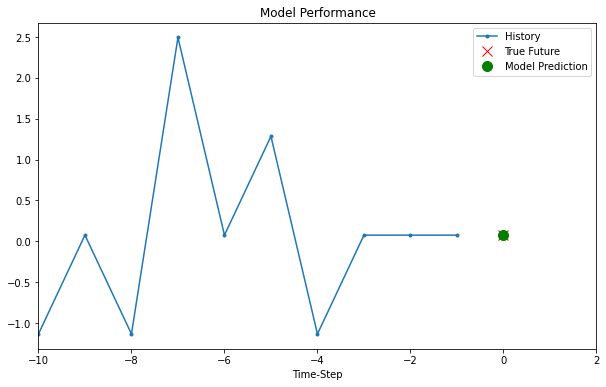

In [310]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Model Performance');

In [0]:
#create df with predicted values for two teams

['Offense_1stD', 'Offense_TotYd', 'Offense_PassY', 'Offense_RushY', 'Offense_TO']

nextgame_dic = {'Opp': ['Kansas City Chiefs', 'San Francisco 49ers'], 
          'Offense_1stD': [18.0, 16.0], 'Offense_TotYd': [310.0, 339.0],
          'Offense_PassY': [180.0, 227.0],	'Offense_RushY': [130.0,	112.0], 
          'Offense_TO': [1.0,	0.0], 'Defense_1stD': [16.0, 18.0],
          'Defense_TotYd':[339.0, 310.0], 'Defense_PassY': [227.0, 180.0], 
          'Defense_RushY': [112.0, 130.0], 'Defense_TO': [0.0, 1.0]}

next_game = pd.DataFrame.from_dict(nextgame_dic, orient = "index")
next_game = next_game.T
next_game['Score_Tm'] = 10
next_game.iloc[:, 1:11] = next_game.iloc[:, 1:11].apply(pd.to_numeric)

## Time Series Forecasting 2 - Prophet

In [0]:
from fbprophet import Prophet

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)


def run_prophet(timeseries):
    model = Prophet()
    model.fit(timeseries)
    forecast = model.make_future_dataframe(periods=1, include_history=False)
    forecast = model.predict(forecast)
    return forecast

In [313]:
#sf49er
target_list = ['Offense_1stD', 'Offense_TotYd', 'Offense_PassY', 'Offense_RushY', 'Offense_TO']

for target in target_list:
  ts_data = nfl_sf_ts[target].reset_index().query('Date >= "2019-09-01"').rename(columns = {'Date':'ds', target: 'y'})
  print(run_prophet(ts_data)['yhat'])

0   19.2
Name: yhat, dtype: float64
0   360.3
Name: yhat, dtype: float64
0   218.3
Name: yhat, dtype: float64
0   141.7
Name: yhat, dtype: float64
0   0.6
Name: yhat, dtype: float64


In [314]:
#chiefs
target_list = ['Offense_1stD', 'Offense_TotYd', 'Offense_PassY', 'Offense_RushY', 'Offense_TO']

for target in target_list:
  ts_data = nfl_ch_ts[target].reset_index().query('Date >= "2019-09-01"').rename(columns = {'Date':'ds', target: 'y'})
  print(run_prophet(ts_data)['yhat'])

0   16.9
Name: yhat, dtype: float64
0   266.2
Name: yhat, dtype: float64
0   124.4
Name: yhat, dtype: float64
0   142.4
Name: yhat, dtype: float64
0   0.9
Name: yhat, dtype: float64


In [0]:
nextgame2_dic = {'Opp': ['Kansas City Chiefs', 'San Francisco 49ers'], 
          'Offense_1stD': [19.2, 16.9], 'Offense_TotYd': [360.6, 266.2],
          'Offense_PassY': [218.3, 124.4],	'Offense_RushY': [141.7,	142.4], 
          'Offense_TO': [0.6,	0.9], 'Defense_1stD': [16.9, 19.2],
          'Defense_TotYd':[266.2, 360.6], 'Defense_PassY': [124.4, 218.3], 
          'Defense_RushY': [142.4, 141.7], 'Defense_TO': [0.9, 0.6]}

next_game2 = pd.DataFrame.from_dict(nextgame2_dic, orient = "index")
next_game2 = next_game2.T
next_game2['Score_Tm'] = 10
next_game2.iloc[:, 1:11] = next_game2.iloc[:, 1:11].apply(pd.to_numeric)


## Linear Regression

In [296]:
nfl_train = nfl_df.query('Date >= "2019-01-01"').drop(['Date', 'WinOrNot', 'HomeField'], axis = 1)
nfl_val = nfl_df.query('Date < "2019-01-01"').drop(['Date', 'WinOrNot', 'HomeField'], axis = 1)
y_train = pd.DataFrame(nfl_train['Score_Tm'])
y_val = pd.DataFrame(nfl_train['Score_Tm'])
print(nfl_train.shape, nfl_val.shape)
display.display(nfl_train.describe())
display.display(y_train.describe())
display.display(nfl_val.describe())
display.display(y_val.describe())

(532, 15) (1602, 15)


,OT,Score_Tm,Score_Opp,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Defense_1stD,Defense_TotYd,Defense_PassY,Defense_RushY,Defense_TO
count,532.0,532.0,532.0,532.0,532.0,532.0,532.0,532.0,532.0,532.0,532.0,532.0,532.0
mean,0.0,22.8,22.8,20.3,348.0,234.4,113.6,1.4,20.3,348.0,234.4,113.6,1.4
std,0.2,10.1,10.1,5.0,88.1,79.6,53.1,1.3,5.0,88.1,79.6,53.1,1.3
min,0.0,0.0,0.0,6.0,105.0,48.0,17.0,0.0,6.0,105.0,48.0,17.0,0.0
25%,0.0,16.0,16.0,17.0,282.0,175.8,75.0,0.0,17.0,282.0,175.8,75.0,0.0
50%,0.0,23.0,23.0,20.5,347.5,233.5,106.0,1.0,20.5,347.5,233.5,106.0,1.0
75%,0.0,30.0,30.0,24.0,409.2,284.2,145.0,2.0,24.0,409.2,284.2,145.0,2.0
max,1.0,59.0,59.0,36.0,643.0,490.0,285.0,7.0,36.0,643.0,490.0,285.0,7.0


,Score_Tm
count,532.0
mean,22.8
std,10.1
min,0.0
25%,16.0
50%,23.0
75%,30.0
max,59.0


,OT,Score_Tm,Score_Opp,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Defense_1stD,Defense_TotYd,Defense_PassY,Defense_RushY,Defense_TO
count,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0
mean,0.1,22.7,22.7,20.0,346.3,235.6,110.7,1.4,20.0,346.3,235.6,110.7,1.4
std,0.2,10.0,10.0,5.0,84.1,77.5,50.0,1.2,5.0,84.1,77.5,50.0,1.2
min,0.0,0.0,0.0,5.0,89.0,6.0,6.0,0.0,5.0,89.0,6.0,6.0,0.0
25%,0.0,16.0,16.0,16.2,288.0,181.0,75.0,0.0,16.2,288.0,181.0,75.0,0.0
50%,0.0,23.0,23.0,20.0,344.0,231.0,103.0,1.0,20.0,344.0,231.0,103.0,1.0
75%,0.0,29.0,29.0,23.0,406.0,287.0,140.0,2.0,23.0,406.0,287.0,140.0,2.0
max,1.0,57.0,57.0,37.0,626.0,500.0,323.0,8.0,37.0,626.0,500.0,323.0,8.0


,Score_Tm
count,532.0
mean,22.8
std,10.1
min,0.0
25%,16.0
50%,23.0
75%,30.0
max,59.0


In [0]:
nfl_df = nfl_df.reindex(np.random.permutation(nfl.index))

In [0]:
def preprocess_features(nfl_df):
  """Prepares input features from nfl data.

  Args:
    nfl_df: A Pandas DataFrame expected to contain data from NFL data set.
  Returns:
    A DataFrame that contains the features to be used for model, including 
    synthetic features.
  """
  selected_features = nfl_df[['Opp', 'Offense_1stD', 'Offense_TotYd',  'Offense_PassY',	 'Offense_RushY',	'Offense_TO',	
                              'Defense_1stD', 'Defense_TotYd',	'Defense_PassY',	'Defense_RushY',	'Defense_TO']]

  processed_features = selected_features.copy()
  return processed_features

def preprocess_targets(nfl_df):
  """Prepares target features from nfl data

  Args:
     nfl_df: A Pandas DataFrame expected to contain data from NFL data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  output_targets['Score_Tm'] = nfl_df['Score_Tm']
  return output_targets


In [299]:
training_examples = preprocess_features(nfl_df.query('Date < "2019-01-01"'))
training_targets = preprocess_targets(nfl_df.query('Date < "2019-01-01"'))

validation_examples = preprocess_features(nfl_df.query('Date >= "2019-01-01"'))
validation_targets = preprocess_targets(nfl_df.query('Date >= "2019-01-01"'))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Defense_1stD,Defense_TotYd,Defense_PassY,Defense_RushY,Defense_TO
count,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0
mean,20.0,346.3,235.6,110.7,1.4,20.0,346.3,235.6,110.7,1.4
std,5.0,84.1,77.5,50.0,1.2,5.0,84.1,77.5,50.0,1.2
min,5.0,89.0,6.0,6.0,0.0,5.0,89.0,6.0,6.0,0.0
25%,16.2,288.0,181.0,75.0,0.0,16.2,288.0,181.0,75.0,0.0
50%,20.0,344.0,231.0,103.0,1.0,20.0,344.0,231.0,103.0,1.0
75%,23.0,406.0,287.0,140.0,2.0,23.0,406.0,287.0,140.0,2.0
max,37.0,626.0,500.0,323.0,8.0,37.0,626.0,500.0,323.0,8.0


Validation examples summary:


,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Defense_1stD,Defense_TotYd,Defense_PassY,Defense_RushY,Defense_TO
count,532.0,532.0,532.0,532.0,532.0,532.0,532.0,532.0,532.0,532.0
mean,20.3,348.0,234.4,113.6,1.4,20.3,348.0,234.4,113.6,1.4
std,5.0,88.1,79.6,53.1,1.3,5.0,88.1,79.6,53.1,1.3
min,6.0,105.0,48.0,17.0,0.0,6.0,105.0,48.0,17.0,0.0
25%,17.0,282.0,175.8,75.0,0.0,17.0,282.0,175.8,75.0,0.0
50%,20.5,347.5,233.5,106.0,1.0,20.5,347.5,233.5,106.0,1.0
75%,24.0,409.2,284.2,145.0,2.0,24.0,409.2,284.2,145.0,2.0
max,36.0,643.0,490.0,285.0,7.0,36.0,643.0,490.0,285.0,7.0


Training targets summary:


,Score_Tm
count,1602.0
mean,22.7
std,10.0
min,0.0
25%,16.0
50%,23.0
75%,29.0
max,57.0


Validation targets summary:


,Score_Tm
count,532.0
mean,22.8
std,10.1
min,0.0
25%,16.0
50%,23.0
75%,30.0
max,59.0


In [0]:
def normalize_features(dataset):
  mu = np.mean(dataset,axis=0)
  sigma = np.std(dataset,axis=0)
  return (dataset - mu)/ sigma

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """

  categorical_columns = ['Opp']
  numeric_columns = ['Offense_1stD', 'Offense_TotYd',  'Offense_PassY',	 'Offense_RushY',	'Offense_TO',	
                    'Defense_1stD',	'Defense_TotYd', 'Defense_PassY',	'Defense_RushY',	'Defense_TO']

  feature_columns = []

  for feature_name in categorical_columns:
    vocabulary = nfl_df[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

  for feature_name in numeric_columns:
    # nfl_df[feature_name] = normalize_features(nfl_df[feature_name])
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

  return set(feature_columns)
  
  
  # return set([tf.feature_column.numeric_column(my_feature, normalizer_fn = tf.contrib.layers.batch_norm)
  #             for my_feature in input_features])


In [0]:
def my_input_fn(features, targets, batch_size = 1, shuffle = True, num_epochs = None):
  """Train a linear regression model.

  Args:
    features: pandas dataframe of features
    targets: pandas dataframe of targets
    batch_size: size of batches to be passed to the model
    shuffle: True or False. whether to shuffle the data
    num_epochs: number of epochs for which data should be repeated. 
                None = repeat indefinitely
  Returns:
    Tuple of (features, labels) for next data batch
  """

  features = {key: np.array(value) for key, value in dict(features).items()}

  ds = Dataset.from_tensor_slices((features, targets))
  ds = ds.batch(batch_size).repeat(num_epochs)

  if shuffle:
    ds = ds.shuffle(10000)

  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels


In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns, 
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Train a linear regression model.
  Args:

  Returns:
    A `LinearRegressor` object trained on the training data
  """ 

  periods = 5
  steps_per_period = steps / periods

  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns = feature_columns,
      optimizer = my_optimizer
  )

  training_input_fn = lambda: my_input_fn(training_examples,
                                          training_targets['Score_Tm'],
                                          batch_size = batch_size
                                          )
  predict_training_input_fn = lambda: my_input_fn(training_examples,
                                                  training_targets['Score_Tm'],
                                                  num_epochs = 1,
                                                  shuffle = False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples,
                                                  validation_targets['Score_Tm'],
                                                  num_epochs = 1,
                                                  shuffle = False)  

  print('Training model:')
  print('RMSE (on training data):')
  training_rmse = []
  validation_rmse = []
  for period in range(0, periods):
    linear_regressor.train(
        input_fn = training_input_fn,
        steps = steps_per_period
    )
    
    training_result = linear_regressor.evaluate(predict_training_input_fn)

    training_predictions = linear_regressor.predict(input_fn = predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    validation_predictions = linear_regressor.predict(input_fn = predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

    training_rmse_value = math.sqrt(
        metrics.mean_squared_error(training_predictions, np.array(training_targets)))
    validation_rmse_value = math.sqrt(
        metrics.mean_squared_error(validation_predictions, np.array(validation_targets)))
    
    print('training: period %02d : %.f' % (period, training_rmse_value))
    print('validation: period %02d : %.f' % (period, validation_rmse_value))
    print(training_result)
    

    training_rmse.append(training_rmse_value)
    validation_rmse.append(validation_rmse_value)

    # accuracy, accuracy_op = tf.metrics.accuracy(labels = tf.argmax(training_targets['Score_Tm'], 0), predictions=tf.argmax(training_predictions, 0))
    # with tf.Session() as sess:
    #   print(sess.run(accuracy))
  print("Model training finished.")

  plt.figure(figsize = [7,4])
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("RMSE / Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label = 'training')
  plt.plot(validation_rmse, label = 'validation')
  plt.ylabel

  return linear_regressor

Training model:
RMSE (on training data):
training: period 00 : 19
validation: period 00 : 19
{'average_loss': 363.61758, 'label/mean': 22.652933, 'loss': 363.61758, 'prediction/mean': 6.124052, 'global_step': 20}
training: period 01 : 14
validation: period 01 : 14
{'average_loss': 191.32043, 'label/mean': 22.652933, 'loss': 191.32043, 'prediction/mean': 12.2407675, 'global_step': 40}
training: period 02 : 10
validation: period 02 : 10
{'average_loss': 96.501305, 'label/mean': 22.652933, 'loss': 96.501305, 'prediction/mean': 18.317581, 'global_step': 60}
training: period 03 : 9
validation: period 03 : 9
{'average_loss': 73.321846, 'label/mean': 22.652933, 'loss': 73.321846, 'prediction/mean': 22.389713, 'global_step': 80}
training: period 04 : 8
validation: period 04 : 8
{'average_loss': 69.911896, 'label/mean': 22.652933, 'loss': 69.911896, 'prediction/mean': 23.02304, 'global_step': 100}
Model training finished.


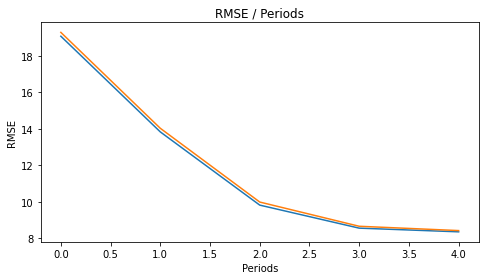

In [381]:
lm = train_model(
    learning_rate = 0.0001,
    steps = 100,
    batch_size = 20,
    feature_columns = construct_feature_columns(training_examples), 
    training_examples = training_examples,
    training_targets = training_targets,
    validation_examples = validation_examples,
    validation_targets = validation_targets
 )

## Prediction

In [316]:
next_game0

,Opp,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Defense_1stD,Defense_TotYd,Defense_PassY,Defense_RushY,Defense_TO,Score_Tm
0,Kansas City Chiefs,20.0,365.5,249.1,109.4,0.9,17.9,349.1,222.4,125.2,1.7,10
1,San Francisco 49ers,17.9,349.1,222.4,125.2,1.7,20.0,365.5,249.1,109.4,0.9,10


In [305]:
#tf
next_game

,Opp,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Defense_1stD,Defense_TotYd,Defense_PassY,Defense_RushY,Defense_TO,Score_Tm
0,Kansas City Chiefs,18.0,310.0,180.0,130.0,1.0,16.0,339.0,227.0,112.0,0.0,10
1,San Francisco 49ers,16.0,339.0,227.0,112.0,0.0,18.0,310.0,180.0,130.0,1.0,10


In [317]:
#prophet
next_game2

,Opp,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Defense_1stD,Defense_TotYd,Defense_PassY,Defense_RushY,Defense_TO,Score_Tm
0,Kansas City Chiefs,19.2,360.6,218.3,141.7,0.6,16.9,266.2,124.4,142.4,0.9,10
1,San Francisco 49ers,16.9,266.2,124.4,142.4,0.9,19.2,360.6,218.3,141.7,0.6,10


In [384]:
#prediction using tf time series model
feature = preprocess_features(next_game0)
target = preprocess_targets(next_game0)
feature_columns = construct_feature_columns(feature)


predict_test_input_fn = lambda: my_input_fn(feature,
                                            target['Score_Tm'],
                                            num_epochs = 1,
                                            shuffle = False)
  
predictions = lm.predict(input_fn = predict_test_input_fn)
predictions = np.array([item['predictions'][0] for item in predictions])


for pred in enumerate(predictions):    
    print(pred)


(0, 23.660034)
(1, 23.49554)


In [385]:
#prediction using tf time series model
feature = preprocess_features(next_game)
target = preprocess_targets(next_game)
feature_columns = construct_feature_columns(feature)


predict_test_input_fn = lambda: my_input_fn(feature,
                                            target['Score_Tm'],
                                            num_epochs = 1,
                                            shuffle = False)
  
predictions = lm.predict(input_fn = predict_test_input_fn)
predictions = np.array([item['predictions'][0] for item in predictions])


for pred in enumerate(predictions):    
    print(pred)


(0, 21.117474)
(1, 21.48024)


In [386]:
#prediction using prophet forecast
feature = preprocess_features(next_game2)
target = preprocess_targets(next_game2)
feature_columns = construct_feature_columns(feature)


predict_test_input_fn = lambda: my_input_fn(feature,
                                            target['Score_Tm'],
                                            num_epochs = 1,
                                            shuffle = False)
  
predictions = lm.predict(input_fn = predict_test_input_fn)
predictions = np.array([item['predictions'][0] for item in predictions])


for pred in enumerate(predictions):    
    print(pred)


(0, 20.886393)
(1, 19.477041)


## Poisson Regression

In [0]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [322]:
df_train = nfl_df.query('Date < "2019-01-01"')
df_test = nfl_df.query('Date >= "2019-01-01"')
print('Training data set length=' + str(len(df_train)))
print('Testing data set length=' + str(len(df_test)))

Training data set length=1602
Testing data set length=532


In [0]:
import patsy

In [324]:
df_train.head(2)

,Date,Team,Opp,WinOrNot,OT,HomeField,Score_Tm,Score_Opp,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Defense_1stD,Defense_TotYd,Defense_PassY,Defense_RushY,Defense_TO
1942,2016-11-20,Green Bay Packers,Washington Redskins,0,0,0,24,42,19,424,340,84,2,21,515,364,151,0
1655,2016-10-09,Miami Dolphins,Tennessee Titans,0,0,1,17,30,8,200,149,51,2,23,398,163,235,0


In [325]:
expr = """Score_Tm ~ Offense_1stD + Offense_TotYd + Offense_PassY + Offense_RushY + Offense_TO +
          Defense_1stD + Defense_TotYd + Defense_PassY + Defense_RushY + Defense_TO"""

y_train, X_train = patsy.dmatrices(expr, df_train, return_type = 'dataframe')
y_test, X_test = patsy.dmatrices(expr, df_test, return_type = 'dataframe')

model = sm.GLM(y_train, X_train, family = sm.families.Poisson())
poisson_training_results = model.fit()
print(poisson_training_results.summary())


#Make some predictions on the test data set.
poisson_predictions = poisson_training_results.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['Score_Tm']

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Score_Tm   No. Observations:                 1602
Model:                            GLM   Df Residuals:                     1593
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5613.5
Date:                Sun, 05 Apr 2020   Deviance:                       3531.5
Time:                        06:34:04   Pearson chi2:                 3.20e+03
No. Iterations:                    16                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.6483      0.037     44.163

<Figure size 720x432 with 0 Axes>

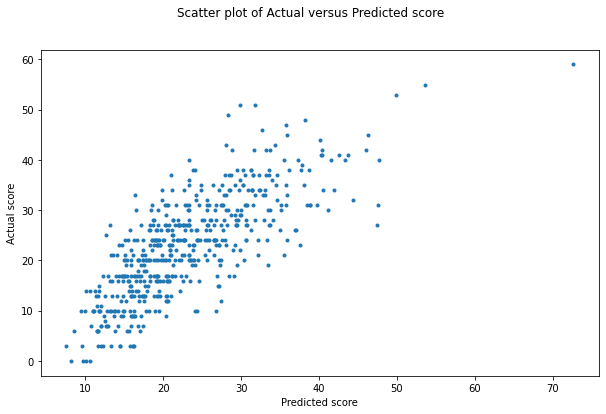

In [326]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted score')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
plt.show()

In [0]:
df_test['Expected_Score'] = predicted_counts.round(0)
df_test['Performance'] = np.where(df_test['Score_Tm'] >= df_test['Expected_Score'], 1, 0)
df_test['Difference'] = df_test['Score_Tm'] - df_test['Expected_Score']

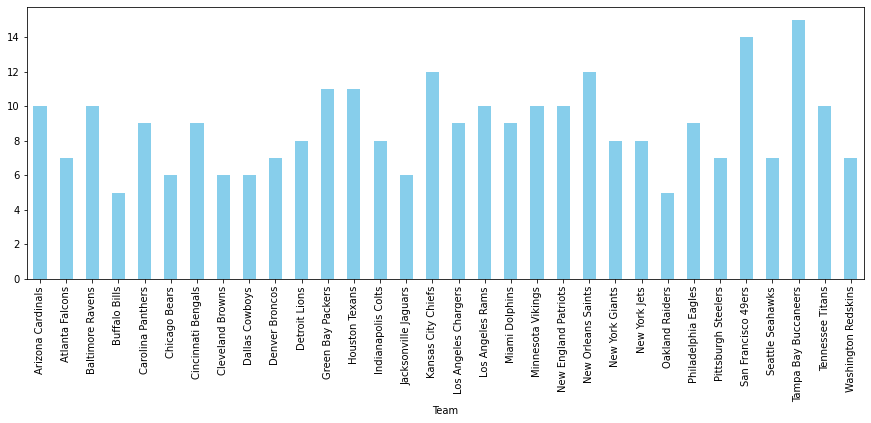

In [328]:
df_test.groupby('Team')['Performance'].sum().plot(kind = 'bar', color = 'skyblue', figsize = (15,5));

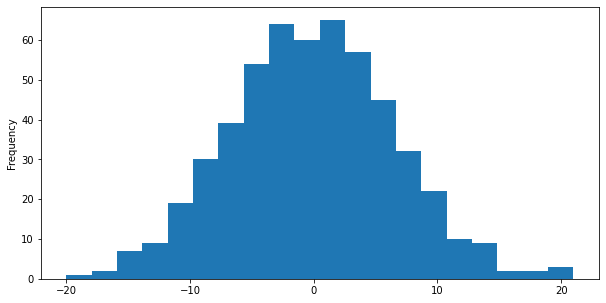

In [329]:
df_test.Difference.plot(kind = 'hist', bins = 20, figsize = [10,5]);

## Prediction

In [0]:
next_game00 = next_game0.loc[:, next_game0.columns != 'Opp']
next_game01 = next_game.loc[:, next_game.columns != 'Opp']
next_game02 = next_game2.loc[:, next_game2.columns != 'Opp']

In [0]:
y_new0, X_new0 = patsy.dmatrices(expr, next_game00, return_type = 'dataframe')
y_new, X_new = patsy.dmatrices(expr, next_game01, return_type = 'dataframe')
y_new2, X_new2 = patsy.dmatrices(expr, next_game02, return_type = 'dataframe')


In [362]:
X_new0

,Intercept,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Defense_1stD,Defense_TotYd,Defense_PassY,Defense_RushY,Defense_TO
0,1.0,20.0,365.5,249.1,109.4,0.9,17.9,349.1,222.4,125.2,1.7
1,1.0,17.9,349.1,222.4,125.2,1.7,20.0,365.5,249.1,109.4,0.9


In [363]:
X_new

,Intercept,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Defense_1stD,Defense_TotYd,Defense_PassY,Defense_RushY,Defense_TO
0,1.0,18.0,310.0,180.0,130.0,1.0,16.0,339.0,227.0,112.0,0.0
1,1.0,16.0,339.0,227.0,112.0,0.0,18.0,310.0,180.0,130.0,1.0


In [364]:
X_new2

,Intercept,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Defense_1stD,Defense_TotYd,Defense_PassY,Defense_RushY,Defense_TO
0,1.0,19.2,360.6,218.3,141.7,0.6,16.9,266.2,124.4,142.4,0.9
1,1.0,16.9,266.2,124.4,142.4,0.9,19.2,360.6,218.3,141.7,0.6


In [365]:
score0 = poisson_training_results.get_prediction(X_new0).summary_frame()['mean']
score1 = poisson_training_results.get_prediction(X_new).summary_frame()['mean']
score2 = poisson_training_results.get_prediction(X_new2).summary_frame()['mean']
print(score0)
print(score1)
print(score2)

0   23.0
1   19.1
Name: mean, dtype: float64
0   16.1
1   20.1
Name: mean, dtype: float64
0   21.3
1   15.7
Name: mean, dtype: float64
